## Computing the efficient frontier: Monte-carlo and optimization

In [6]:
library(quantmod)
library(ggplot2)
library(arrayhelpers)
options(repr.plot.width=7, repr.plot.height=3)

We start off by choosing tickers from yahoo finance. We store all tickers in the variable **symbols** and call the data from yahoo finance with the **quantmod** function: **getSymbols()**. We compute quickly the returns and store them in the variable **Returns**

In [22]:
symbols = c('FB', 'OKTA', 'ADT', 'TSLA', 'EQT')

x_1 = getSymbols(symbols[1], env=NULL)
x_2 = getSymbols(symbols[2], env=NULL)
x_3 = getSymbols(symbols[3], env=NULL)
x_4 = getSymbols(symbols[4], env=NULL)
x_5 = getSymbols(symbols[5], env=NULL)


Stocks = cbind(x_1[,6], x_2[,6], x_3[,6], x_4[,6], x_5[,6])
Returns = diff(log(Stocks))
Returns[is.na(Returns)] = 0
head(Returns)

           FB.Adjusted OKTA.Adjusted ADT.Adjusted TSLA.Adjusted  EQT.Adjusted
2007-01-03           0             0            0             0  0.0000000000
2007-01-04           0             0            0             0 -0.0044648240
2007-01-05           0             0            0             0 -0.0137690434
2007-01-08           0             0            0             0  0.0211999940
2007-01-09           0             0            0             0  0.0002469435
2007-01-10           0             0            0             0  0.0041859870

We compute the vector of all expectation for each variable such as: 

$ Esp = \left[ E[X_1], ... , E[X_5] \right] $ 

We use the **arrayhelpers** package to compute mean of all columns 

And $Cov$ is the covariance matrix of all returns. 

In [23]:
Esp = colMeans(Returns)
Cov = cov(Returns)

Esp 
Cov

FB.Adjusted OKTA.Adjusted  ADT.Adjusted TSLA.Adjusted  EQT.Adjusted 
 0.0004966990  0.0004757364 -0.0001264869  0.0008177443 -0.0001242970

,FB.Adjusted,OKTA.Adjusted,ADT.Adjusted,TSLA.Adjusted,EQT.Adjusted
FB.Adjusted,2.999969e-04,4.459149e-05,1.624051e-05,9.090143e-05,5.028887e-05
OKTA.Adjusted,4.459149e-05,1.975247e-04,1.400663e-05,3.983219e-05,5.839971e-06
ADT.Adjusted,1.624051e-05,1.400663e-05,1.245645e-04,2.806773e-05,2.470789e-05
TSLA.Adjusted,9.090143e-05,3.983219e-05,2.806773e-05,7.636602e-04,9.643671e-05
EQT.Adjusted,5.028887e-05,5.839971e-06,2.470789e-05,9.643671e-05,5.748480e-04


Now, the goal is to represent the empirical efficient frontier. We will simulate a given number of portfolio of our 5 stocks. We will generate random weights in order to get different portfolios. We hope to have a visual proof of the diversification effect. 

We will generate random weights by using the function **sample**. The function give 5 numbers taken from any number between 1 and 1000 with same probability. In order to be certain that the sum of all weights equal to 1, we divide each number by their sum. 

Also, we create a matrix to store our results for each simulation (**mc_port**). The dataframe has 3 columns for, respectively, the expected return of the portfolio, the standard deviation and the sharpe ratio (given the risk-free asset have an expected return of 0).

In [24]:
# Specify number of portfolio simulation I want 
n_simu= 20000
mc_port = data.frame(matrix(ncol=3, nrow=n_simu))

Quite simply, the expected return of a portfolio is the vector of weights multiplied by the vector of expected returns: 

$$ E[X_{port}] = x^T \cdot Esp $$ 

Also, the variance of a portfolio is given by: 

$$ Var[X_{port}] = x^T \cdot \Sigma \cdot x$$

So, standard deviation is: 

$$ SD[X_{port}] = (x^T \cdot \Sigma \cdot x)^{1/2}$$

In [25]:
for (i in 1:n_simu){
  w = as.matrix(sample(1:1000, 5, replace=F))
  w = w/sum(w)
  
  mc_port[i,1] = t(w) %*% Esp
  mc_port[i,2] = sqrt(t(w) %*% Cov %*% w)
  mc_port[i,3] = mc_port[i,1]/mc_port[i,2]
}

colnames(mc_port)=c('mean', 'sd', 'sharpe')
head(mc_port)

mean,sd,sharpe
0.0002805208,0.011203052,0.02503968
0.0002784453,0.008887305,0.03133068
0.0001618551,0.009562554,0.01692592
0.0002101145,0.009167930,0.02291842
0.0003829977,0.013110068,0.02921401
0.0002676354,0.011301611,0.02368117


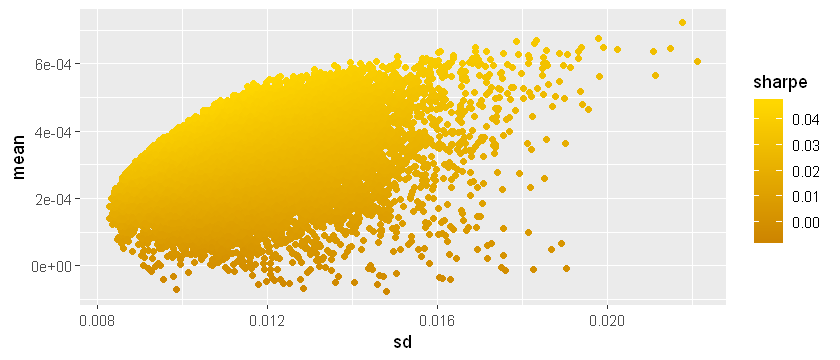

In [26]:
p <- ggplot() + geom_jitter(data=mc_port, aes(x=sd, y=mean, colour=sharpe)) + 
  scale_color_gradient(low='orange3', high='gold')
p  

### Computing the minimum variance portfolio

Now that we have seen that empirically the diversification effect has a limit which is the efficient frontier, let's try to get some of the most "famous" portfolios. We start we the Global Mininum Variance (GMV) portfolio. 

Mathematically, the problem shows as: 

$$  \min_{x} Var[X_{port}] =  x^{T} \Sigma x   $$
$$ s.c. $$
$$ x^{T} \mathbb{I} = 1 $$

We will see the algebra in class in order to get to the closed form solution of this problem: 

$$ x^{*} = \frac{\Sigma^{-1} \cdot \mathbb{I}}{\mathbb{I}^T \cdot \Sigma^{-1} \cdot \mathbb{I}} $$

Easy, right ?

To transform this mathematical formulation into R code, we need to separate the components of the equation. if not, the code will end up being messy and not easy to read. 

$ \mathbb{I} $ is the identity vector, so it is a repetition of ones. We can use the function **rep()** to create it. The function **solve()** give us the inverse of the covariance matrix. Finally, we separate the top and bottom of the equation before computing the result. More separation in your operations, the easiest it is to spot mistakes! 

In [27]:
one.vec= rep(1,5)
top = (solve(Cov)%*%one.vec)
bot = (t(one.vec)%*%solve(Cov)%*%one.vec)
x_min = top/as.numeric(bot)
x_min

FB.Adjusted,0.13919337
OKTA.Adjusted,0.27270716
ADT.Adjusted,0.47833834
TSLA.Adjusted,0.03140695
EQT.Adjusted,0.07835418


We are now computing the expected return, variance and sharpe ration of the GMV. We are storing it in a dataframe in order to facilitate the visualization with **ggplot2** later on 

In [28]:
min_var_port = data.frame(matrix(nrow=1, ncol=3))
min_var_port[1] = t(x_min)%*%Esp 
min_var_port[2] = sqrt(t(x_min)%*%Cov%*%x_min)
min_var_port[3] = min_var_port[1]/min_var_port[2]
colnames(min_var_port) = c('mean_min', 'sd_min', 'sharpe_min')

Note that the GMV data is not in the simulations of portfolio data ! So we specify the **data** and **aes()** inside the type of plot. Respectively, in **geom_jitter** and **geom_point**. 

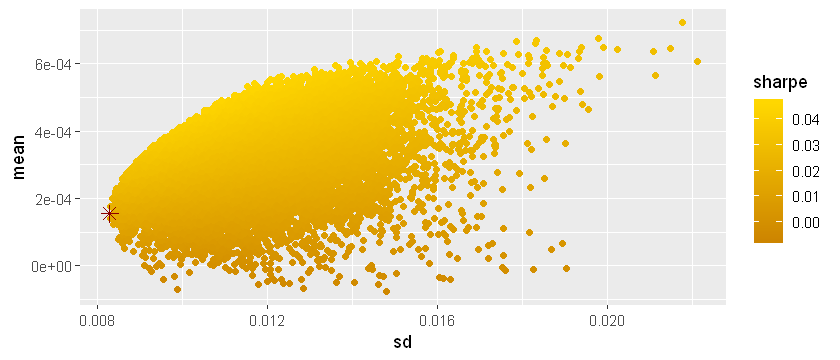

In [29]:
p1 <- ggplot() + geom_jitter(data=mc_port, aes(x=sd, y=mean, colour=sharpe)) +
  scale_color_gradient(low='orange3', high='gold') + 
  geom_point(data=min_var_port, aes(x=sd_min, y=mean_min),shape=8, size=3, color='darkred') 
p1

### Computing the maximum expected return portfolio 

Even though diversification can reduce the variance of the portfolio compared to the individual variance of stocks, we cannot do the opposite for the expected return. The maxium expected that we will have will be the the maximum expected return amongst our stocks. 

We will use the function **max()** to get the maximum expected return in our return vector: $Esp$. 

The algebra become a bit more tricky for this issue but nothing impossible! We define the optimization problem as: 

$$ \min_{x} Var[X_{port}] $$ 
$$s.c.$$
$$\mu_{port} = \mu_{max}$$
$$x^T \cdot \mathbb{I} $$ 

Similarly, we will go through the algebra in class but the closed form solution is: 

$$ x_{min} = A^{-1} \cdot b_0 $$ 

with

$$ A = 
\begin{pmatrix} 
2\Sigma & \mu & \mathbb{I} \\
\mu^T & 0 & 0 \\
\mathbb{I}^T & 0 & 0 
\end{pmatrix}
$$

$$ b_0 =
\begin{pmatrix}
0 \\
\mu_{max} \\
1
\end{pmatrix}
$$


We specify first the top matrix, using the functions **cbind()** to add each component in columns. 
And we add all rows together with **rbind()**.


In [30]:
#portfolio with highest return
top_mat = cbind(2*Cov, Esp, rep(1,5))
mid_vec = c(t(Esp), 0, 0)
bot_vec = c(rep(1,5), 0, 0)
A_mat = rbind(top_mat, mid_vec, bot_vec)
x_vec = c(rep(0,5), max(Esp), 1)

weight_opti = solve(A_mat)%*%x_vec
weight_opti = weight_opti[1:5]
weight_opti

[1]  0.4073015  0.7009263 -0.2908415  0.2843745 -0.1017608

Same than precedently, we compute the expected return, variance and sharpe of the maximum return portfolio and store it in a dataframe to facilitate the visualization with **ggplot2**

In [31]:
max_rt_port = data.frame(matrix(nrow=1, ncol=3))
max_rt_port[,1] = weight_opti%*%Esp
max_rt_port[,2] = sqrt(weight_opti%*%Cov%*%t(t(weight_opti)))
max_rt_port[,3] = max_rt_port[,1]/max_rt_port[,2]
colnames(max_rt_port) = c('mean_max', 'sd_max', 'sharpe_max')

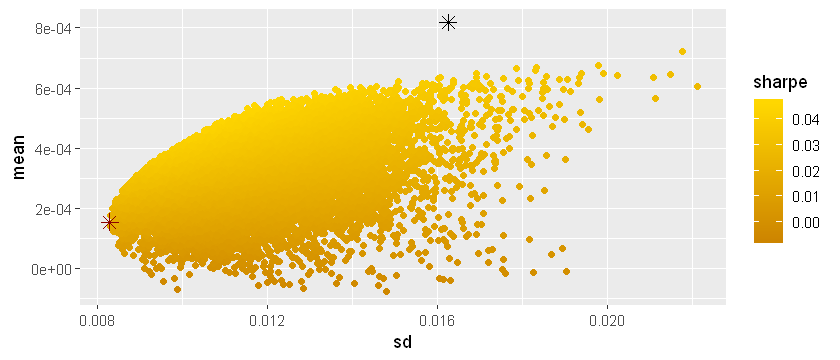

In [32]:
p2 <- ggplot() + 
  geom_jitter(data=mc_port, aes(x = sd, y = mean, colour=sharpe)) +
  scale_colour_gradient(low = "orange3", high = "gold") +
  geom_point(data=min_var_port, aes(x=sd_min, y=mean_min), shape=8, size=3, color='darkred') + 
  geom_point(data=max_rt_port, aes(x=sd_max, y=mean_max), shape=8, size=3, color='black')

p2

### Compute the tangency Portfolio

Since the algebra gets more and more tricky starting from here, we will use the fact that we have simulated a lot of portfolio to approximate the tangency portfolio (this is a sort of Monte-carlo approximation of the tangency portfolio (TP)). 

In general the TP respond to the following maximization problem: 

$$ \max_t = \frac{t^T \cdot \mu - r_f}{(t^T \cdot \Sigma\cdot t)^{1/2}} $$

In simpler term, it maximize the Sharpe ratio of the portfolio. 

In our approximation we just need to get the simulated portfolio with the highest sharpe ratio. We use the function **max()** for this. 

Similarly, we add it to our precedent plots

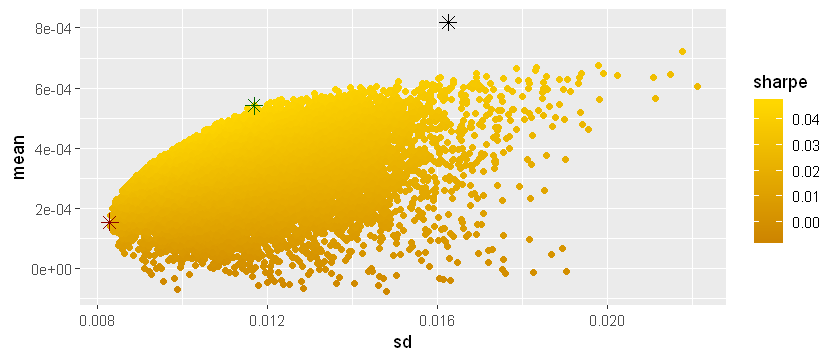

In [33]:
# Portfolio with the highest sharpe ratio 
max_sh_port = data.frame(matrix(nrow=1, ncol=3))
pre_max =  sort(mc_port[,'sharpe'], decreasing=T, index.return=T)
max_sh_port[1] = mc_port[pre_max$ix[1], 'mean']
max_sh_port[2] = mc_port[pre_max$ix[1],'sd']
max_sh_port[3] = pre_max$x[1]
colnames(max_sh_port) = c('mean_max', 'sd_max', 'sharpe_max')

p3 <- ggplot() + 
  geom_jitter(data=mc_port, aes(x = sd, y = mean, colour=sharpe)) +
  scale_colour_gradient(low = "orange3", high = "gold") +
  geom_point(data=min_var_port, aes(x=sd_min, y=mean_min), shape=8, size=3, color='darkred') + 
  geom_point(data=max_rt_port, aes(x=sd_max, y=mean_max), shape=8, size=3, color='black') +
  geom_point(data=max_sh_port, aes(x=sd_max, y=mean_max), shape=8, size=3, color='darkgreen')

p3

Here are the annualized returns for each portfolio 

In [34]:
print((1+ max_rt_port[,'mean_max'])**250-1)
print((1+ max_sh_port[,'mean_max'])**250-1)
print((1+ min_var_port[,'mean_min'])**250-1)

          [,1]
[1,] 0.2267305
[1] 0.1448778
           [,1]
[1,] 0.03932924


### Compute the theoritical efficient frontier

The last thing to do is to be assured that the efficient frontier estimated with Monte-Carlo is the same than the theoritically obtained one. 

The methodology is quite straight forward. We know to compute the efficient portfolio with a target expected return. We need just to compute portfolios for all expected returns situated between the one of the GMV and the maximum return portfolio. 

We use the function **seq()** to create the vector of target expected returns. We create a dataframe (**eff_frontier2**) in order to store all the portfolios computed. 

By creating a *for* loop we compute all the portfolios for all target expected returns in **mus**. The variable *r* is only used here to move down for one row after each computations.

We implement then the result in our previous graph.

Warning message in from + (0L:n) * by:
"Recycling array of length 1 in array-vector arithmetic is deprecated.
  Use c() or as.vector() instead.
"

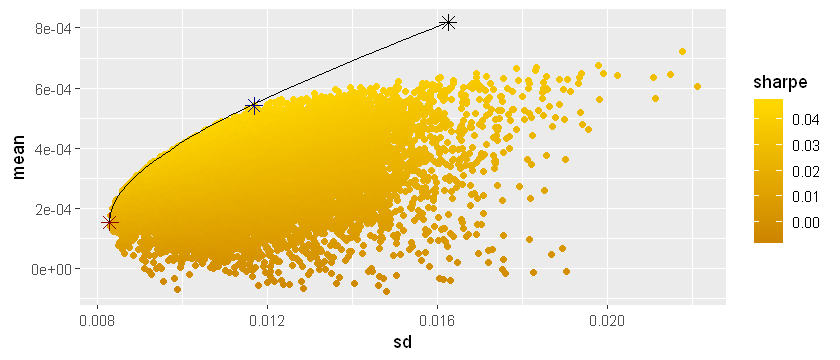

In [35]:
mus = seq(min_var_port[,'mean_min'],max_rt_port[,'mean_max'],0.00001)
eff_frontier2 = data.frame(matrix(nrow=length(mus), ncol=2))

r = 1
for(i in mus){
  top_mat = cbind(2*Cov, Esp, rep(1,5))
  mid_vec = c(t(Esp), 0, 0)
  bot_vec = c(rep(1,5), 0, 0)
  A_mat = rbind(top_mat, mid_vec, bot_vec)
  x_vec = c(rep(0,5), i, 1)
  
  weight_opti2 = solve(A_mat)%*%x_vec
  weight_opti2 = weight_opti2[1:5]
  
  eff_frontier2[r,1] = weight_opti2%*%Esp
  eff_frontier2[r,2] = sqrt(weight_opti2%*%Cov%*%t(t(weight_opti2)))
  r = r+1
}

colnames(eff_frontier2) = c('means', 'sd')

p5 <- ggplot() + 
  geom_jitter(data=mc_port, aes(x = sd, y = mean, colour=sharpe)) +
  scale_colour_gradient(low = "orange3", high = "gold") +
  geom_point(data=min_var_port, aes(x=sd_min, y=mean_min), shape=8, size=3, color='darkred') + 
  geom_point(data=max_rt_port, aes(x=sd_max, y=mean_max), shape=8, size=3, color='black') +
  geom_point(data=max_sh_port, aes(x=sd_max, y=mean_max), shape=8, size=3, color='darkblue') + 
  geom_line(data=eff_frontier2, aes(x=sd, y=means), color='black')

p5

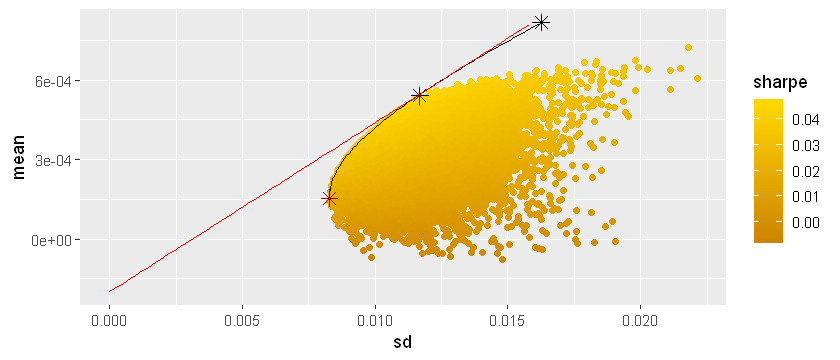

In [36]:
#to go further: Optimization with a riskfree asset 

rf= -0.0002
mus = seq(rf,max_rt_port[,'mean_max'],0.00001)
eff_frontier3 = data.frame(matrix(nrow=length(mus), ncol=2))

r = 1
for(i in mus){
  top_mat = solve(Cov)%*%(Esp-rf)
  bot_mat = (i - rf)/(as.numeric(t(Esp-rf)%*%solve(Cov)%*%(Esp-rf)))
  weight_opti3 = top_mat*bot_mat
  weight_opti3 = weight_opti3[1:5]
  
  eff_frontier3[r,1] = weight_opti3%*%Esp + (1 - rep(1,5)%*%weight_opti3)*rf
  eff_frontier3[r,2] = sqrt(weight_opti3%*%Cov%*%t(t(weight_opti3)))
  r = r+1
}

colnames(eff_frontier3) = c('means', 'sd')

p6 <- ggplot() + 
  geom_jitter(data=mc_port, aes(x = sd, y = mean, colour=sharpe)) +
  scale_colour_gradient(low = "orange3", high = "gold") +
  geom_point(data=min_var_port, aes(x=sd_min, y=mean_min), shape=8, size=3, color='darkred') + 
  geom_point(data=max_rt_port, aes(x=sd_max, y=mean_max), shape=8, size=3, color='black') +
  geom_point(data=max_sh_port, aes(x=sd_max, y=mean_max), shape=8, size=3, color='darkblue') + 
  geom_line(data=eff_frontier2, aes(x=sd, y=means), color='black') +
  geom_line(data=eff_frontier3, aes(x=sd, y=means), color='red')

p6